# Курсовой проект  "Python для Data Science"

Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации

## Подключение библиотек и скриптов

In [7]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

Загрузка данных и оптимизация памяти

In [8]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'VergizovAA_predictions.csv'

In [9]:
df = pd.read_csv('train.csv', index_col=0, encoding='utf-8', sep =",")

In [10]:
# Функция для преобразования категориальных переменных в булевые
def bool_func (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [11]:
# Функция для оптимизации памяти

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



In [12]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 2.96 MB
Memory usage after optimization is: 0.54 MB
Decreased by 81.6%


## Предобработка данных, выбор модели

In [13]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


In [14]:
df.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [15]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['LifeSquare'].median()
df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     10000 non-null  float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   10000 non-null  float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-nul

### Работа с категориальными признаками

In [17]:
category = df.select_dtypes(include='category').columns
category

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

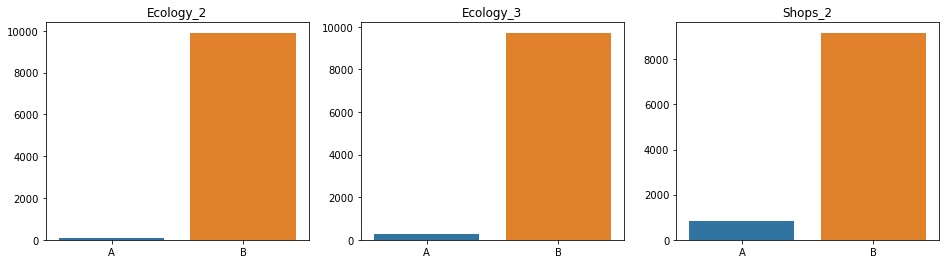

In [18]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(category):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    

plt.show()

In [107]:
# Преобразование категориальных признаков

bool_func(category, df)

### Работа с количественными признаками

In [120]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
Id,,,,,,,
14038,2.0,47.981560,29.442751,6.0,9.0,0.089040,900.0
15053,3.0,65.683640,40.049541,8.0,9.0,0.000070,240.0
4765,2.0,44.947952,29.197611,0.0,12.0,0.049637,229.0
5809,2.0,53.352982,52.731510,9.0,17.0,0.437885,1084.0
10783,1.0,39.649193,23.776169,7.0,12.0,0.012339,2078.0
...,...,...,...,...,...,...,...
77,2.0,50.401787,30.476204,5.0,5.0,0.135650,350.0
6159,1.0,41.521545,20.539215,9.0,13.0,0.000000,900.0
5123,1.0,47.939007,32.781261,1.0,16.0,0.072158,900.0


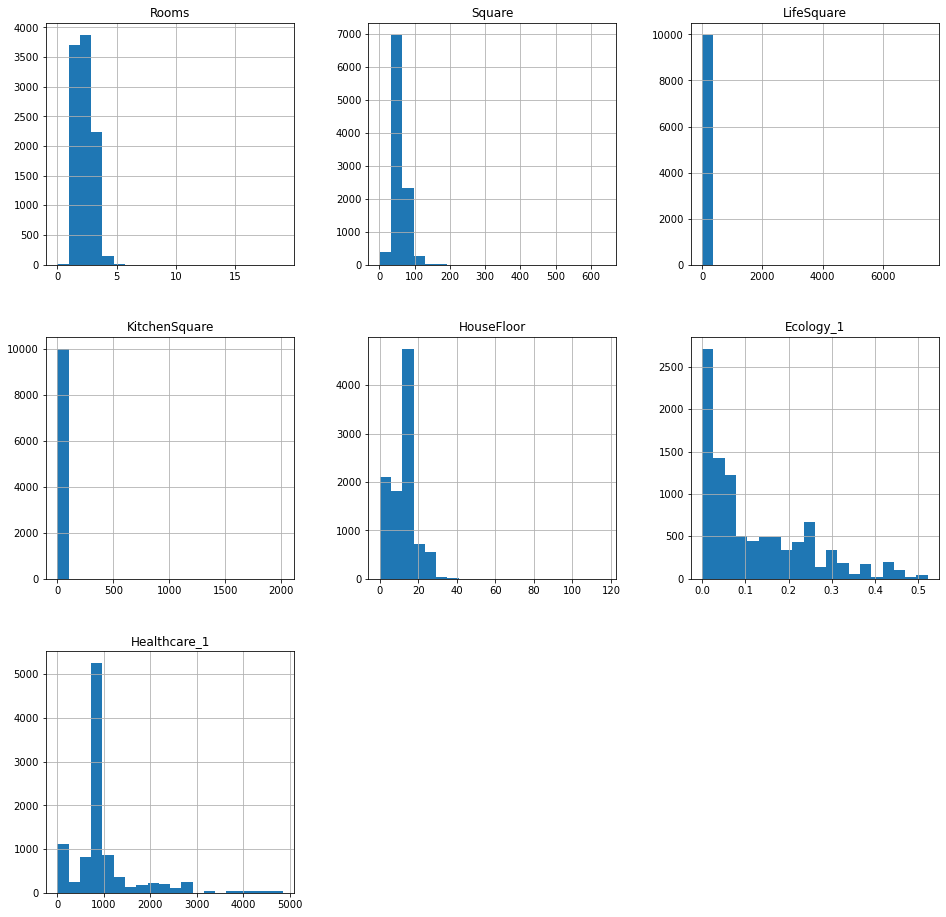

In [109]:
df_num_features.hist(figsize=(16,16), bins=20, grid=True);

### Поиск и устранение выбросов

Используя boxplot определим и устраним выбросы

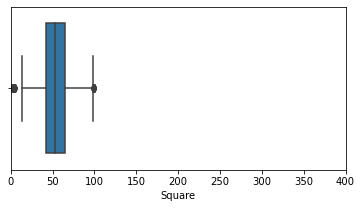

In [142]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['Square'], whis=1.5)
plt.xlabel('Square')
plt.xlim(0, 400)
plt.show()

In [141]:
df.loc[df['Square'] > 100, 'Square'] = df['Square'].median()

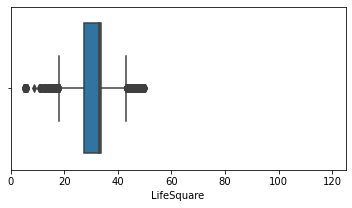

In [157]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')
plt.xlim(0, 125)
plt.show()

In [156]:
df.loc[(df['LifeSquare'] < 5) | (df['LifeSquare'] > 50), 'LifeSquare'] = df['LifeSquare'].median()

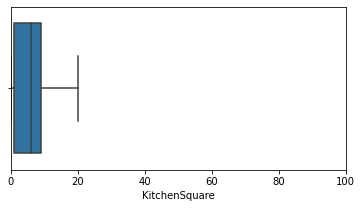

In [149]:
plt.figure(figsize=(6, 3))
sns.boxplot(df['KitchenSquare'], whis=1.5)
plt.xlabel('KitchenSquare')
plt.xlim(0, 100)
plt.show()

In [144]:
df.loc[df['KitchenSquare'] > 20, 'KitchenSquare'] = df['KitchenSquare'].median()

In [145]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,54.440357,32.367100,5.67570,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358887,1.319500,4.231300,214139.218750
std,43.587592,0.839523,15.738066,10.074560,3.87462,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,746.645447,1.493601,4.806341,92872.304688
min,0.000000,0.000000,1.136859,0.370619,0.00000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,25.527400,1.00000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513039,32.781261,6.00000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,64.538017,35.979424,9.00000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,99.893005,59.973251,20.00000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## Определение более эффективного метода

Разделение выборок на тренировочную и валидационную

In [162]:
X = df.drop(labels=['Price'], axis=1)
y= df['Price'].values

In [163]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [164]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [165]:
model_dict = {
   'lr': LinearRegression(),
#    'lasso': Lasso(random_state=42),
#    'ridge': Ridge(random_state=42),
#    'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')
    



lr: 
	train: 0.4993 
	valid: 0.4907
knn: 
	train: 0.7688 
	valid: 0.6286
dt: 
	train: 0.9999 
	valid: 0.4536
rf: 
	train: 0.9601 
	valid: 0.7189


Лучшие показатели у модели "Random Forrest"

R_2= 0.7189

Будем использовать данную модель

### Настройка параметров модели с RandomizedSearchCV

In [167]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 31.3min finished


0.7316168141083873
{'n_estimators': 340, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 42}


Определение качества модели

In [171]:
y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print(f'train: {np.round(score_train, 4)}\nvalid: {np.round(score_valid, 4)}')

train: 0.9416
valid: 0.7278


### Обучение модели

In [172]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=26,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled, y)

scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)

print(f'cv mean: {np.round(np.mean(scores), 4)}')
print(f'cv std:  {np.round(np.std(scores), 4)}')

cv mean: 0.7395
cv std:  0.0233


# Предобработка тестового датасета

In [174]:
df_real = pd.read_csv('test.csv', index_col=0, encoding='utf-8')

In [201]:
df_real.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,False,False,11,2748,1,900.0,0,0,False
15856,74,2.0,69.263183,32.925087,1.0,6,1.0,1977,0.075779,False,False,6,1437,3,900.0,0,2,False
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,False,False,30,7538,87,4702.0,5,5,False
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,False,False,23,4583,3,900.0,3,3,False
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,False,False,2,629,1,900.0,0,0,True


In [176]:
df_real.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       1041
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     2377
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

In [177]:
df_real.loc[df_real['LifeSquare'].isnull(), 'LifeSquare'] = df_real['LifeSquare'].median()
df_real.loc[df_real['Healthcare_1'].isnull(), 'Healthcare_1'] = df_real['Healthcare_1'].median()

In [179]:
category_test = df_real.select_dtypes(include='object').columns
category_test

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

In [180]:
bool_func(category_test, df_real)

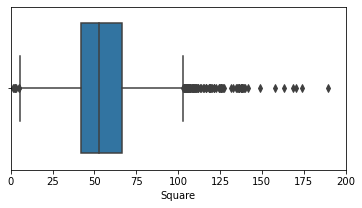

In [196]:
plt.figure(figsize=(6, 3))
sns.boxplot(df_real['Square'], whis=1.5)
plt.xlabel('Square')
plt.xlim(0, 200)
plt.show()

In [194]:
df_real.loc[df_real['Square'] > 100, 'Square'] = df_real['Square'].median()

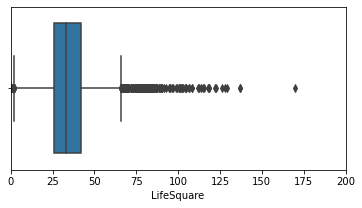

In [189]:
plt.figure(figsize=(6, 3))
sns.boxplot(df_real['LifeSquare'], whis=1.5)
plt.xlabel('LifeSquare')
plt.xlim(0, 200)
plt.show()

In [191]:
df_real.loc[df_real['LifeSquare'] > 60, 'LifeSquare'] = df_real['LifeSquare'].median()

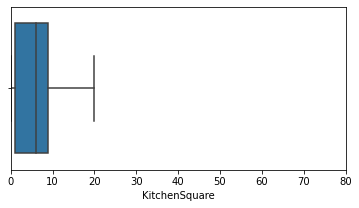

In [199]:
plt.figure(figsize=(6, 3))
sns.boxplot(df_real['KitchenSquare'], whis=1.5)
plt.xlabel('KitchenSquare')
plt.xlim(0, 80)
plt.show()

In [198]:
df_real.loc[df_real['KitchenSquare'] > 20, 'KitchenSquare'] = df_real['KitchenSquare'].median()

# Предсказание целевой переменной

In [19]:
df_real.shape()

NameError: name 'df_real' is not defined

In [208]:
X_test = df_real


In [209]:
X_test_scaled = scaler.transform(X_test)

In [211]:
y_pred_new = model.predict(X_test_scaled)


In [213]:
predictions = pd.DataFrame({
    'Id': X_test.index,
    'Price': y_pred_new
})

In [214]:
predictions.head()


,Id,Price
0,725,164959.774633
1,15856,238376.083108
2,5480,221086.732316
3,15664,332042.723260
4,14275,142635.935015


In [215]:
predictions.to_csv('VergizovAA_predictions.csv', sep=',', index=False, encoding='utf-8')
